In [1]:
import os
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_task_checkpoints(task_dir: str, agg_list: list[dict]=[]):
    agg_num = 0
    if agg_list:
        agg_num = agg_list[-1]['agg_checkpoint']

    checkpoints = []
    files = [f for f in os.listdir(task_dir) if f.endswith('.json')]

    checkpoint_files = []
    for filename in files:
        match = re.search(r'checkpoint-(\d+)\.json', filename)
        if match:
            num = int(match.group(1))
            checkpoint_files.append((num, filename))

    checkpoint_files.sort(key=lambda x: x[0])
    
    for i, filename in enumerate(checkpoint_files):
        checkpoint_path = os.path.join(task_dir, filename[1])
        data_dict = {}

        with open(checkpoint_path, 'r') as f:
            data = json.load(f)
            data_dict['graph']= data
        
        data_dict['local_checkpoint'] = filename[0]
        data_dict['agg_checkpoint'] = data_dict['local_checkpoint'] + agg_num
        checkpoints.append(data_dict)

    agg_list.extend(checkpoints)
    return agg_list

def get_sequential_checkpoints(total_dir:str) -> list[dict]:
    agg_list = []

    task_dir = []
    folders = [f for f in os.listdir(total_dir) if os.path.isdir(os.path.join(total_dir, f))]
    for folder in folders:
        match = re.search(r'task(\d+)', folder)
        if match:
            num = int(match.group(1))
            full_path = os.path.join(total_dir, folder)
            task_dir.append((num, full_path))

    task_dir.sort(key=lambda x: x[0])

    for _ , dir in task_dir:
        agg_list = get_task_checkpoints(dir, agg_list)

    return agg_list

In [6]:
def count_nodes_per_checkpoint(checkpoints):
    node_counts = []
    for checkpoint in checkpoints:
        nodes = checkpoint['nodes']
        true_count = sum(1 for node, state in nodes.items() if state)
        node_counts.append(true_count)
    return node_counts

def calculate_node_changes(checkpoints):
    changes = []
    added_ls =[]
    removed_ls = []

    for i in range(1, len(checkpoints)):
        prev_nodes = checkpoints[i - 1]['nodes']
        curr_nodes = checkpoints[i]['nodes']

        added = sum(1 for node in curr_nodes if curr_nodes[node] and not prev_nodes.get(node, False))
        removed = sum(1 for node in prev_nodes if prev_nodes[node] and not curr_nodes.get(node, False))
        added_ls.append(added)
        removed_ls.append(removed)

        changes.append(added + removed)

    return changes, added_ls, removed_ls

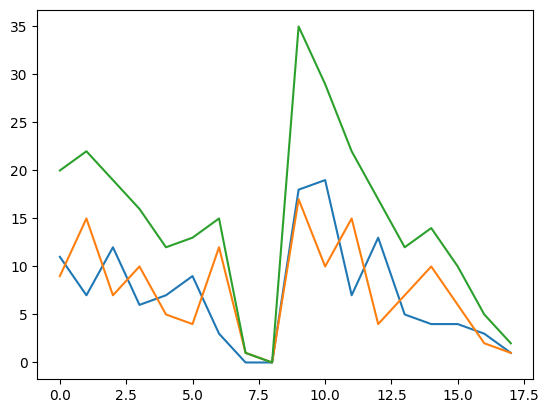

In [8]:
checkpoints = get_sequential_checkpoints("../graphs/sequential_fine_tuning/add_sub_100/")
graphs = [i['graph'] for i in checkpoints]
agg_checkpoints = [i['agg_checkpoint'] for i in checkpoints] 
node_changes,added_ls, removed_ls = calculate_node_changes(graphs)
plt.plot(removed_ls)
plt.plot(added_ls)
plt.plot(node_changes)

/tmp/ipykernel_4167838/2259436564.py:25: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


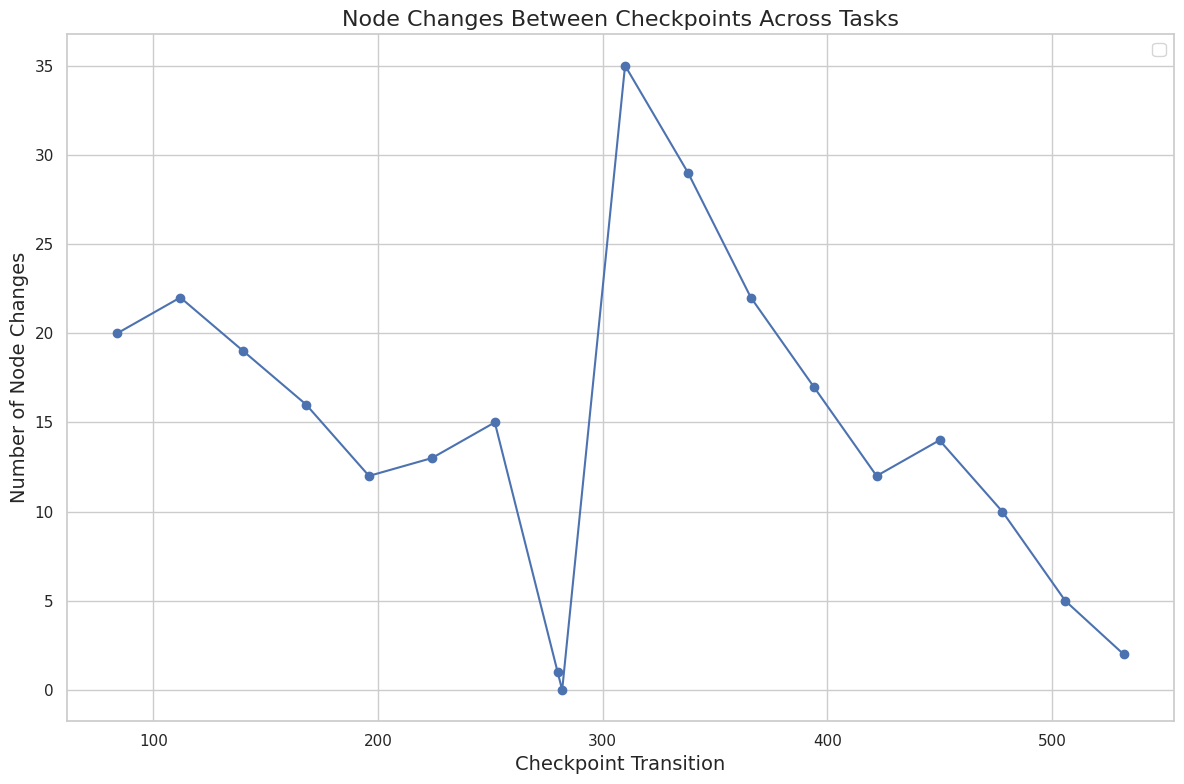

In [11]:
def visualize_sequential_fine_tuning(total_dir: str):
    sns.set_theme(style="whitegrid")

    all_node_counts = []
    all_node_changes = []
    
    checkpoints = get_sequential_checkpoints(total_dir)

    graphs = [i['graph'] for i in checkpoints]
    agg_checkpoints = [i['agg_checkpoint'] for i in checkpoints] 
  
    node_counts = count_nodes_per_checkpoint(graphs)
    node_changes = calculate_node_changes(graphs)
    transitions = range(1, len(node_changes) + 1)

    all_node_counts.append(node_counts)
    all_node_changes.append(node_changes)

    plt.figure(figsize=(12, 8))
    plt.plot(agg_checkpoints[1:], node_changes, marker='o', linestyle='-')

    plt.xlabel('Checkpoint Transition', fontsize=14)
    plt.ylabel('Number of Node Changes', fontsize=14)
    plt.title('Node Changes Between Checkpoints Across Tasks', fontsize=16)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

visualize_sequential_fine_tuning("../graphs/sequential_fine_tuning/add_sub_100/")

/tmp/ipykernel_4167838/2993987511.py:38: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(fontsize=12)


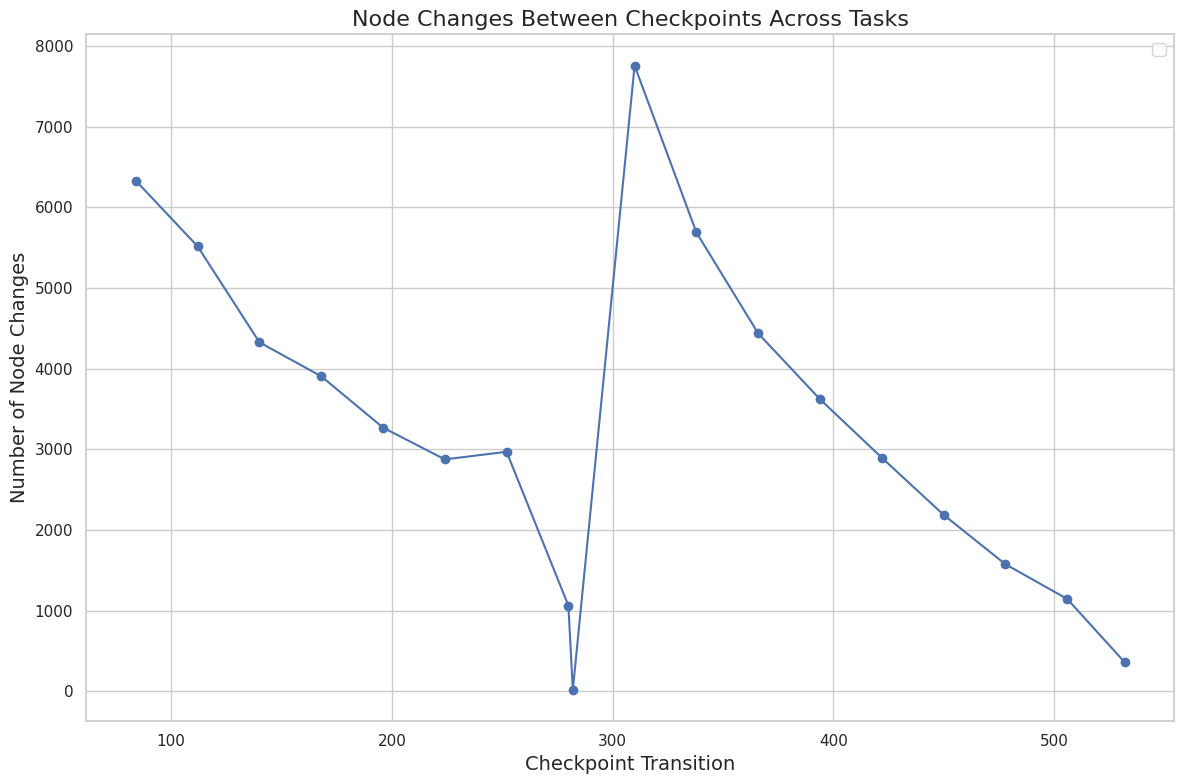

In [13]:
def calculate_in_graph_changes_per_checkpoint(checkpoints):
    in_graph_changes = []

    for i in range(1, len(checkpoints)):
        prev_edges = checkpoints[i - 1]['edges']
        curr_edges = checkpoints[i]['edges']
        change_count = 0

        for edge in curr_edges.keys():
            prev_in_graph = prev_edges.get(edge, {}).get('in_graph', False)
            curr_in_graph = curr_edges[edge]['in_graph']
            if prev_in_graph != curr_in_graph: 
                change_count += 1

        in_graph_changes.append(change_count)

    return in_graph_changes

def visualize_sequential_fine_tuning_edges(total_dir: str):
    sns.set_theme(style="whitegrid")
    
    checkpoints = get_sequential_checkpoints(total_dir)

    graphs = [i['graph'] for i in checkpoints]
    agg_checkpoints = [i['agg_checkpoint'] for i in checkpoints] 
  
    task_changes = calculate_in_graph_changes_per_checkpoint(graphs)

    plt.figure(figsize=(12, 8))
    plt.plot(agg_checkpoints[1:], task_changes, marker='o', linestyle='-')

    plt.xlabel('Checkpoint Transition', fontsize=14)
    plt.ylabel('Number of Node Changes', fontsize=14)
    plt.title('Node Changes Between Checkpoints Across Tasks', fontsize=16)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

visualize_sequential_fine_tuning_edges("../graphs/sequential_fine_tuning/add_sub_100/")

In [14]:
checkpoints = get_sequential_checkpoints("../graphs/sequential_fine_tuning/add_sub_100/")

In [18]:
len(checkpoints[-1]['graph']['edges'])

231493